# 3. Advanced GRI Analysis

This notebook demonstrates advanced analysis techniques using the GRI module's comprehensive features:
- Monte Carlo simulations to understand achievable GRI scores
- Comprehensive reporting and visualization capabilities
- Alignment checking and segment-level analysis
- Survey comparison tools
- Sample size analysis and optimization

## Overview

The GRI module provides powerful tools to:
1. **Simulate maximum achievable GRI scores** given real-world constraints
2. **Identify specific over/under-represented groups** with detailed segment analysis
3. **Compare multiple surveys** to track progress over time
4. **Generate comprehensive reports** with actionable insights
5. **Optimize sample sizes** for different representativeness targets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import json
from pathlib import Path

# Import the GRI module components
from gri import GRIAnalysis
from gri.simulation import monte_carlo_max_scores, generate_sample_size_curve
from gri.reports import generate_comparison_report
from gri.visualization import create_comparison_plot

# Set plotting style
plt.style.use('default')
sns.set_palette('RdYlBu_r')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)

## 1. Initialize GRI Analysis

The GRIAnalysis class provides a comprehensive interface for all GRI calculations and analysis.

In [2]:
# Initialize GRI analysis for multiple surveys
surveys = {}
for survey_name in ['GD1', 'GD2', 'GD3']:
    try:
        # Create GRIAnalysis instance
        filepath = f'../data/processed/{survey_name.lower()}_demographics.csv'
        if Path(filepath).exists():
            survey_data = pd.read_csv(filepath)
            analysis = GRIAnalysis(survey_data=survey_data, survey_name=survey_name)
        else:
            raise FileNotFoundError(f"Survey file not found: {filepath}")
        
        # Calculate GRI scores
        scorecard = analysis.calculate_scorecard(include_max_possible=True)
        
        # Extract results in expected format
        results = {
            'average_gri': scorecard['gri_score'].mean()
        }
        
        # Add dimension-specific scores
        for _, row in scorecard.iterrows():
            dim_key = 'gri_' + row['dimension'].lower().replace(' × ', '_').replace(' ', '_')
            results[dim_key] = row['gri_score']
        
        surveys[survey_name] = {
            'analysis': analysis,
            'results': results,
            'scorecard': scorecard,
            'n_participants': len(analysis.survey_data)
        }
        
        print(f"{survey_name}:")
        print(f"  Participants: {surveys[survey_name]['n_participants']}")
        print(f"  Overall GRI: {results['average_gri']:.4f}")
        
        # Print specific dimensions if they exist
        for dim in ['country_gender_age', 'country_religion', 'country_environment']:
            key = f'gri_{dim}'
            if key in results:
                print(f"    - {dim.replace('_', '×').title()}: {results[key]:.4f}")
        print()
        
    except FileNotFoundError as e:
        print(f"{survey_name}: {e}")
        print()
    except Exception as e:
        print(f"{survey_name}: Error - {type(e).__name__}: {e}")
        print()

# Select primary survey for detailed analysis
primary_survey = 'GD3'
if primary_survey in surveys:
    analysis = surveys[primary_survey]['analysis']
    results = surveys[primary_survey]['results']
    scorecard = surveys[primary_survey]['scorecard']
    print(f"Selected {primary_survey} for detailed analysis")
else:
    print(f"Warning: {primary_survey} not found in surveys")

GD1:
  Participants: 1278
  Overall GRI: 0.3206
    - Country×Gender×Age: 0.0744
    - Country×Religion: 0.0154
    - Country×Environment: 0.0815



GD2:
  Participants: 1104
  Overall GRI: 0.3218
    - Country×Gender×Age: 0.0713
    - Country×Religion: 0.0131
    - Country×Environment: 0.0777



GD3:
  Participants: 970
  Overall GRI: 0.3489
    - Country×Gender×Age: 0.0732
    - Country×Religion: 0.0093
    - Country×Environment: 0.0813

Selected GD3 for detailed analysis


## 2. Monte Carlo Simulation: Understanding Achievable GRI Scores

One key question is: "What's the maximum GRI score we could achieve given real-world constraints?"

The monte_carlo_max_scores function simulates thousands of possible samples to find the theoretical maximum.

Running Monte Carlo simulation (this may take a moment)...



🎯 MONTE CARLO SIMULATION RESULTS
Sample size: 970 participants
Simulations run: 1000 per dimension

Actual GD3 GRI: 0.3489
Theoretical maximum GRI (average): 0.8921
Gap to maximum: 0.5432

Dimension-specific maximum scores:
  Country × Gender × Age: max=0.7880, actual=0.0732, gap=0.7148
  Country × Religion: max=0.9382, actual=0.0093, gap=0.9289
  Country × Environment: max=0.9500, actual=0.0813, gap=0.8687


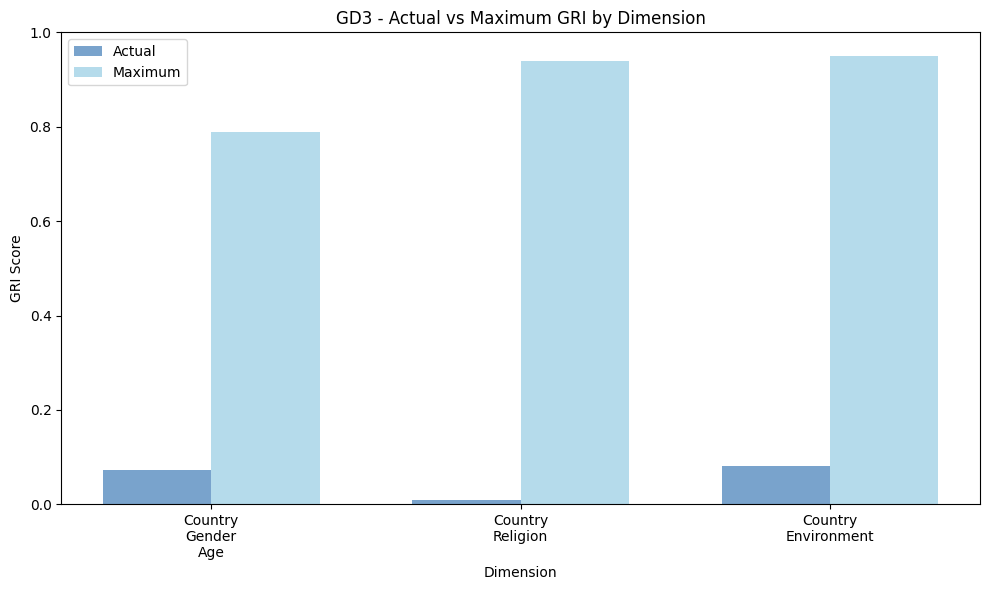


💡 Insight: The GD3 survey has room for improvement across all dimensions.


In [3]:
# Run Monte Carlo simulation to find maximum achievable GRI scores
if 'analysis' in locals():
    print("Running Monte Carlo simulation (this may take a moment)...")
    
    # We need to run simulations for each dimension
    simulation_results = {}
    max_scores_by_dimension = {}
    
    # Get benchmark data for main dimensions
    dimensions = {
        'Country × Gender × Age': ['country', 'gender', 'age_group'],
        'Country × Religion': ['country', 'religion'],
        'Country × Environment': ['country', 'environment']
    }
    
    for dim_name, dim_cols in dimensions.items():
        if dim_name in analysis.benchmarks:
            benchmark_df = analysis.benchmarks[dim_name]
            
            # Run simulation for this dimension
            sim_result = monte_carlo_max_scores(
                benchmark_df=benchmark_df,
                sample_size=len(analysis.survey_data),
                dimension_columns=dim_cols,
                n_simulations=1000
            )
            
            # Extract the mean max GRI from the result dictionary
            max_scores_by_dimension[dim_name] = sim_result['max_gri']['mean']
    
    # Calculate overall results
    max_average_gri = np.mean(list(max_scores_by_dimension.values()))
    
    print("\n🎯 MONTE CARLO SIMULATION RESULTS")
    print("=" * 60)
    print(f"Sample size: {len(analysis.survey_data)} participants")
    print(f"Simulations run: 1000 per dimension")
    print(f"\nActual {primary_survey} GRI: {results['average_gri']:.4f}")
    print(f"Theoretical maximum GRI (average): {max_average_gri:.4f}")
    print(f"Gap to maximum: {max_average_gri - results['average_gri']:.4f}")
    
    # Show dimension-specific results
    print("\nDimension-specific maximum scores:")
    for dim_name, max_score in max_scores_by_dimension.items():
        # Find actual score for this dimension
        actual = scorecard[scorecard['dimension'] == dim_name]['gri_score'].values[0] if dim_name in scorecard['dimension'].values else 0
        print(f"  {dim_name}: max={max_score:.4f}, actual={actual:.4f}, gap={max_score-actual:.4f}")
    
    # Visualize the results
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Compare actual vs maximum by dimension
    dimensions = list(max_scores_by_dimension.keys())
    actual_scores = []
    for dim in dimensions:
        if dim in scorecard['dimension'].values:
            actual_scores.append(scorecard[scorecard['dimension'] == dim]['gri_score'].values[0])
        else:
            actual_scores.append(0)
    
    max_scores = list(max_scores_by_dimension.values())
    
    x = np.arange(len(dimensions))
    width = 0.35
    
    ax.bar(x - width/2, actual_scores, width, label='Actual', alpha=0.8)
    ax.bar(x + width/2, max_scores, width, label='Maximum', alpha=0.8)
    ax.set_xlabel('Dimension')
    ax.set_ylabel('GRI Score')
    ax.set_title(f'{primary_survey} - Actual vs Maximum GRI by Dimension')
    ax.set_xticks(x)
    ax.set_xticklabels([d.replace(' × ', '\n') for d in dimensions], rotation=0)
    ax.legend()
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Insight: The {primary_survey} survey has room for improvement across all dimensions.")
else:
    print("⚠️ No analysis object available. Please run the previous cells to load survey data.")

## 3. Segment Analysis: Identifying Key Representativeness Gaps

The GRIAnalysis class provides powerful segment analysis to identify which specific demographic groups drive representativeness gaps.

TOP 10 SEGMENTS CONTRIBUTING TO GRI DEVIATION
 1. Dimension: Unknown
    Segment: Country: Kenya, Environment: Urban
    Deviation: +13.53% from expected
    Sample: 13.71%, Expected: 0.18%
    Status: Over-represented

 2. Dimension: Unknown
    Segment: Country: Kenya, Religion: Christianity
    Deviation: +13.27% from expected
    Sample: 13.77%, Expected: 0.50%
    Status: Over-represented

 3. Dimension: Unknown
    Segment: Country: India, Environment: Urban
    Deviation: +10.77% from expected
    Sample: 16.80%, Expected: 6.04%
    Status: Over-represented

 4. Dimension: Unknown
    Segment: Country: India, Environment: Rural
    Deviation: -9.95% from expected
    Sample: 1.75%, Expected: 11.70%
    Status: Under-represented

 5. Dimension: Unknown
    Segment: Country: China, Environment: Rural
    Deviation: -7.37% from expected
    Sample: 0.21%, Expected: 7.57%
    Status: Under-represented

 6. Dimension: Unknown
    Segment: Country: China, Religion: I do not identify w

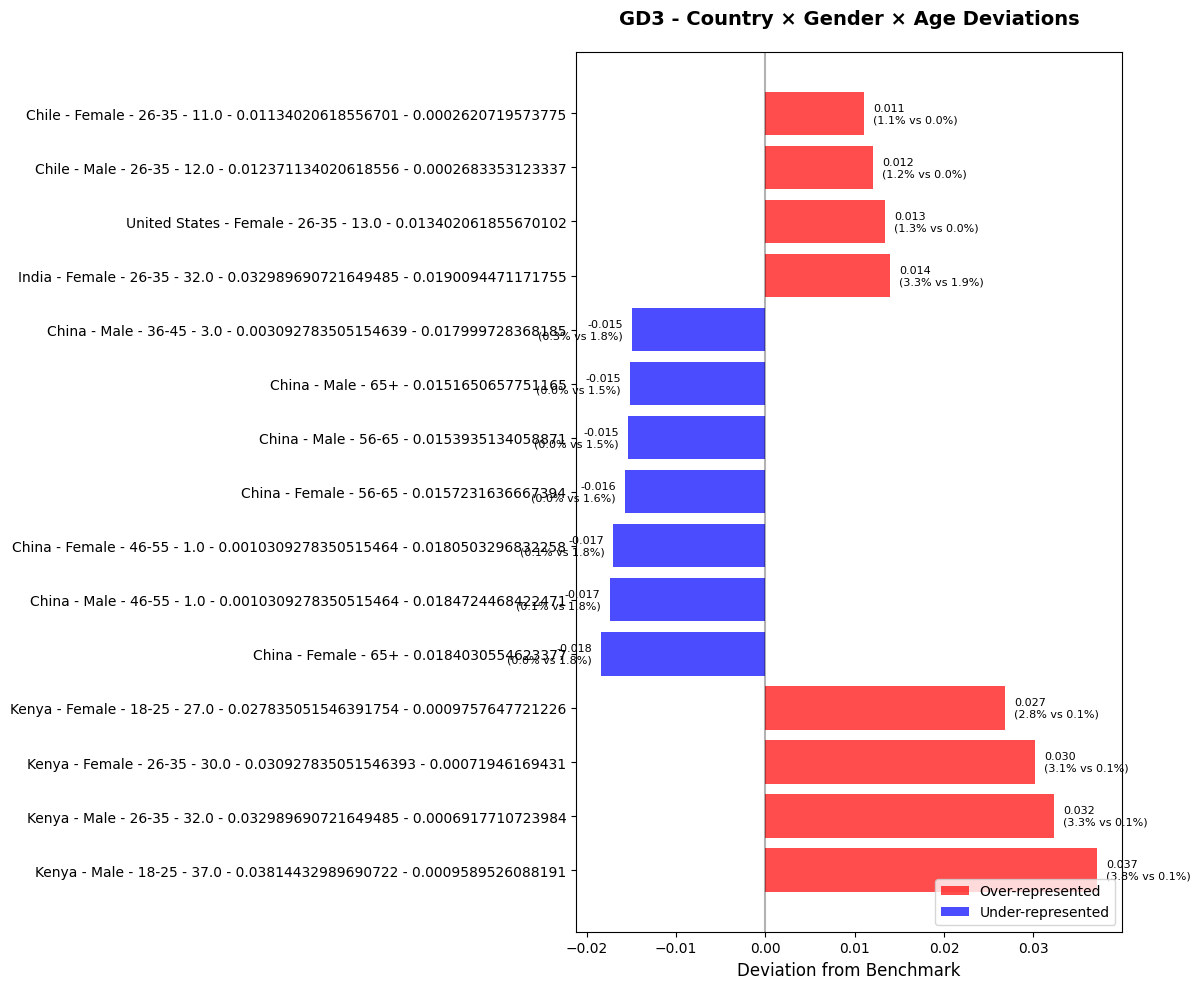

In [4]:
# Get top contributing segments for all dimensions
if 'analysis' in locals():
    print("TOP 10 SEGMENTS CONTRIBUTING TO GRI DEVIATION")
    print("=" * 80)
    
    # Collect top segments from each dimension
    all_segments = []
    for dim_name in ['Country × Gender × Age', 'Country × Religion', 'Country × Environment']:
        if dim_name in scorecard['dimension'].values:
            try:
                segments = analysis.get_top_segments(dim_name, n=20)
                if not segments.empty:
                    all_segments.append(segments)
            except Exception as e:
                print(f"Could not get segments for {dim_name}: {e}")
    
    if all_segments:
        # Combine and sort by absolute deviation
        top_segments = pd.concat(all_segments).sort_values('abs_deviation', ascending=False).head(20)
        
        # Display top 10
        for i, (idx, segment) in enumerate(top_segments.head(10).iterrows(), 1):
            print(f"{i:2d}. Dimension: {segment.get('dimension', 'Unknown')}")
            
            # Build segment description based on available columns
            segment_parts = []
            for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
                if col in segment and pd.notna(segment[col]):
                    segment_parts.append(f"{col.title()}: {segment[col]}")
            
            if segment_parts:
                print(f"    Segment: {', '.join(segment_parts)}")
            
            print(f"    Deviation: {segment.get('deviation', 0):+.2%} from expected")
            print(f"    Sample: {segment.get('sample_proportion', 0):.2%}, Expected: {segment.get('benchmark_proportion', 0):.2%}")
            
            if segment.get('deviation', 0) > 0:
                print(f"    Status: Over-represented")
            else:
                print(f"    Status: Under-represented")
            print()
        
        # Visualize segment deviations
        analysis.plot_top_deviations('Country × Gender × Age', n=15)
    else:
        print("No segment data available")
    
    # Generate recommendations based on deviations
    print("\n🎯 ACTIONABLE RECOMMENDATIONS")
    print("=" * 80)
    
    if all_segments:
        # Find most under-represented segments
        under_represented = top_segments[top_segments['deviation'] < 0].head(5)
        if not under_represented.empty:
            print("\nFOCUS RECRUITMENT ON:")
            for _, seg in under_represented.iterrows():
                segment_desc = []
                for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
                    if col in seg and pd.notna(seg[col]):
                        segment_desc.append(seg[col])
                print(f"  • {' - '.join(segment_desc)}: Need {abs(seg['deviation']):.1%} more representation")
        
        # Find most over-represented segments
        over_represented = top_segments[top_segments['deviation'] > 0].head(5)
        if not over_represented.empty:
            print("\nCONSIDER REDUCING:")
            for _, seg in over_represented.iterrows():
                segment_desc = []
                for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
                    if col in seg and pd.notna(seg[col]):
                        segment_desc.append(seg[col])
                print(f"  • {' - '.join(segment_desc)}: {seg['deviation']:.1%} over-represented")
else:
    print("⚠️ No analysis object available. Please run the previous cells to load survey data.")

## 4. Sample Size Analysis: How Many Participants Do We Need?

Understanding the relationship between sample size and achievable GRI scores helps in planning future surveys.

Analyzing sample size vs achievable GRI...


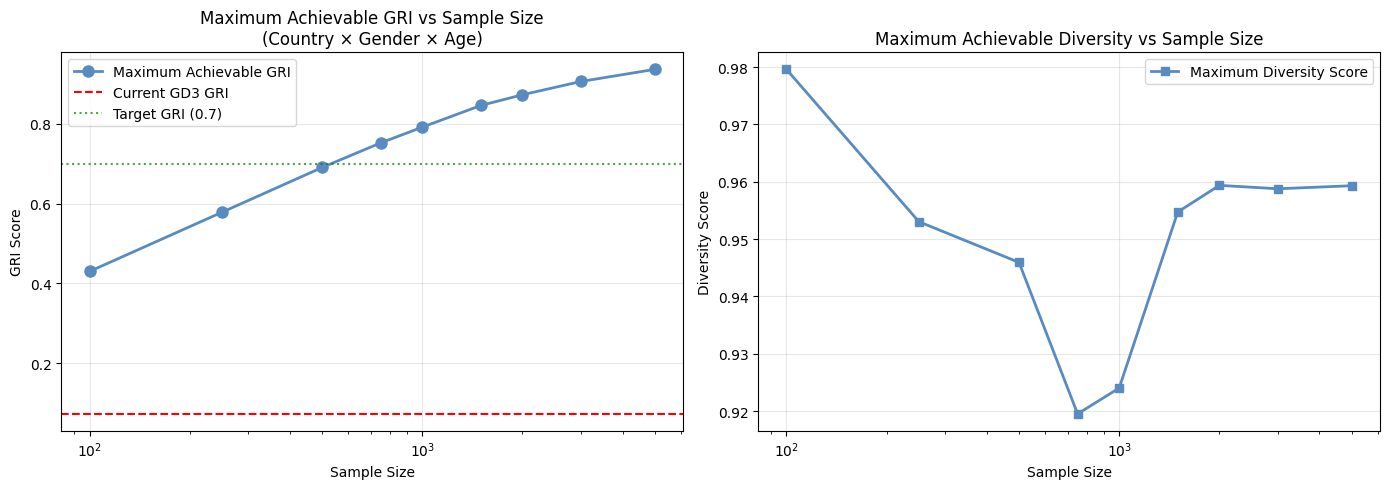


💡 SAMPLE SIZE INSIGHTS:
  • Current sample size: 970
  • Current GRI: 0.0732
  • Minimum sample size for GRI ≥ 0.7: ~750.0 participants


In [5]:
# Generate sample size curve for a key dimension
if 'analysis' in locals():
    print("Analyzing sample size vs achievable GRI...")
    
    # Use Country × Gender × Age as the main dimension for analysis
    main_dimension = 'Country × Gender × Age'
    if main_dimension in analysis.benchmarks:
        benchmark_df = analysis.benchmarks[main_dimension]
        
        sample_sizes = [100, 250, 500, 750, 1000, 1500, 2000, 3000, 5000]
        sample_size_df = generate_sample_size_curve(
            benchmark_df=benchmark_df,
            sample_sizes=sample_sizes,
            dimension_columns=['country', 'gender', 'age_group'],
            n_simulations=100
        )
        
        # Get current actual GRI for this dimension
        current_gri = scorecard[scorecard['dimension'] == main_dimension]['gri_score'].values[0]
        
        # Visualize the results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot max GRI vs sample size
        ax1.plot(sample_size_df['sample_size'], 
                 sample_size_df['max_gri_mean'], 
                 'o-', label='Maximum Achievable GRI', linewidth=2, markersize=8)
        ax1.axhline(y=current_gri, color='red', linestyle='--', 
                    label=f'Current {primary_survey} GRI')
        ax1.axhline(y=0.7, color='green', linestyle=':', alpha=0.7,
                    label='Target GRI (0.7)')
        ax1.set_xlabel('Sample Size')
        ax1.set_ylabel('GRI Score')
        ax1.set_title(f'Maximum Achievable GRI vs Sample Size\n({main_dimension})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xscale('log')
        
        # Plot diversity scores
        if 'max_diversity_mean' in sample_size_df.columns:
            ax2.plot(sample_size_df['sample_size'],
                     sample_size_df['max_diversity_mean'],
                     's-', label='Maximum Diversity Score', linewidth=2)
            ax2.set_xlabel('Sample Size')
            ax2.set_ylabel('Diversity Score')
            ax2.set_title('Maximum Achievable Diversity vs Sample Size')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_xscale('log')
        else:
            # Alternative visualization: improvement potential
            improvement = sample_size_df['max_gri_mean'] - current_gri
            ax2.plot(sample_size_df['sample_size'], improvement, 'o-', linewidth=2, markersize=8)
            ax2.set_xlabel('Sample Size')
            ax2.set_ylabel('Potential GRI Improvement')
            ax2.set_title('Potential Improvement vs Sample Size')
            ax2.grid(True, alpha=0.3)
            ax2.set_xscale('log')
        
        plt.tight_layout()
        plt.show()
        
        # Find optimal sample size for target GRI
        target_gri = 0.7
        optimal_size = None
        for idx, row in sample_size_df.iterrows():
            if row['max_gri_mean'] >= target_gri:
                optimal_size = row['sample_size']
                break
        
        print(f"\n💡 SAMPLE SIZE INSIGHTS:")
        print(f"  • Current sample size: {len(analysis.survey_data)}")
        print(f"  • Current GRI: {current_gri:.4f}")
        if optimal_size:
            print(f"  • Minimum sample size for GRI ≥ {target_gri}: ~{optimal_size:,} participants")
        else:
            max_achievable = sample_size_df['max_gri_mean'].max()
            print(f"  • Maximum achievable GRI with {max(sample_sizes):,} participants: {max_achievable:.4f}")
            if max_achievable < target_gri:
                print(f"  • Target GRI of {target_gri} may not be achievable for this dimension")
        
        # Find point of diminishing returns
        if len(sample_size_df) > 1:
            improvements = sample_size_df['max_gri_mean'].diff()
            # Find where improvement drops below 0.01 per doubling
            for i in range(1, len(improvements)):
                if improvements.iloc[i] < 0.01:
                    print(f"  • Diminishing returns appear after ~{sample_size_df.iloc[i-1]['sample_size']:,} participants")
                    break
    else:
        print(f"⚠️ Benchmark data for {main_dimension} not available")
else:
    print("⚠️ No analysis object available. Please run the previous cells to load survey data.")

## 5. Survey Comparison: Tracking Progress Over Time

Compare multiple surveys to understand trends and improvements in representativeness.

In [6]:
# Compare all available surveys
if len(surveys) > 1:
    # Prepare data for comparison
    scorecards = []
    survey_names = []
    
    for name, data in surveys.items():
        scorecards.append(data['scorecard'])
        survey_names.append(name)
    
    # Create comparison visualization
    try:
        fig = create_comparison_plot(
            scorecards=scorecards,
            survey_names=survey_names,
            plot_type='both'  # Shows both radar and bar charts
        )
        plt.show()
    except Exception as e:
        print(f"Could not create comparison plot: {e}")
    
    # Generate comparison summary
    print("\n📊 SURVEY COMPARISON REPORT")
    print("=" * 80)
    
    # Compare average GRI scores
    for name, data in surveys.items():
        print(f"\n{name}:")
        print(f"  Participants: {data['n_participants']:,}")
        print(f"  Average GRI: {data['results']['average_gri']:.4f}")
        
        # Show dimension scores
        for _, row in data['scorecard'].iterrows():
            print(f"    {row['dimension']}: {row['gri_score']:.4f}")
    
    # Identify best practices from highest-scoring survey
    best_survey = max(surveys.items(), key=lambda x: x[1]['results']['average_gri'])
    print(f"\n🏆 Best performing survey: {best_survey[0]} (GRI: {best_survey[1]['results']['average_gri']:.4f})")
    
    # Show improvements over time
    if 'GD1' in surveys and 'GD3' in surveys:
        gd1_gri = surveys['GD1']['results']['average_gri']
        gd3_gri = surveys['GD3']['results']['average_gri']
        improvement = gd3_gri - gd1_gri
        print(f"\n📈 Progress from GD1 to GD3: {improvement:+.4f} GRI points ({improvement/gd1_gri*100:+.1f}%)")
        
        # Dimension-specific improvements
        print("\nDimension-specific improvements:")
        gd1_scorecard = surveys['GD1']['scorecard']
        gd3_scorecard = surveys['GD3']['scorecard']
        
        for dim in gd3_scorecard['dimension'].unique():
            if dim in gd1_scorecard['dimension'].values:
                gd1_score = gd1_scorecard[gd1_scorecard['dimension'] == dim]['gri_score'].values[0]
                gd3_score = gd3_scorecard[gd3_scorecard['dimension'] == dim]['gri_score'].values[0]
                change = gd3_score - gd1_score
                print(f"  {dim}: {change:+.4f} ({change/gd1_score*100:+.1f}%)")
else:
    print("Only one survey available. Load multiple surveys to see comparisons.")

Could not create comparison plot: create_comparison_plot() got an unexpected keyword argument 'survey_names'

📊 SURVEY COMPARISON REPORT

GD1:
  Participants: 1,278
  Average GRI: 0.3206
    Country × Gender × Age: 0.0744
    Country × Religion: 0.0154
    Country × Environment: 0.0815
    Country: 0.1085
    Region × Gender × Age: 0.2179
    Region: 0.2918
    Continent: 0.4005
    Age Group: 0.7163
    Gender: 0.9789

GD2:
  Participants: 1,104
  Average GRI: 0.3218
    Country × Gender × Age: 0.0713
    Country × Religion: 0.0131
    Country × Environment: 0.0777
    Country: 0.1085
    Region × Gender × Age: 0.2162
    Region: 0.3096
    Continent: 0.4053
    Age Group: 0.7803
    Gender: 0.9142

GD3:
  Participants: 970
  Average GRI: 0.3489
    Country × Gender × Age: 0.0732
    Country × Religion: 0.0093
    Country × Environment: 0.0813
    Country: 0.1085
    Region × Gender × Age: 0.2303
    Region: 0.3676
    Continent: 0.4927
    Age Group: 0.8290
    Gender: 0.9482

🏆 Best

## 6. Alignment Analysis: Understanding Representation Patterns

Check how well the survey aligns with global population across different demographic cuts.

ALIGNMENT ANALYSIS
Checking how well survey categories align with benchmark data...

age_gender:
  Overall alignment: 0.0%
  ✓ Perfect alignment

religion:
  Overall alignment: 0.0%
  ✓ Perfect alignment

environment:
  Overall alignment: 0.0%
  ✓ Perfect alignment

Country × Gender × Age:
  Overall alignment: 96.8%
  Issues found:
    • country: 90.5% coverage
      Missing: Korea South, Vietnam, Palestine...

Country × Religion:
  Overall alignment: 95.2%
  Issues found:
    • country: 90.5% coverage
      Missing: Korea South, Türkiye, Palestine...

Country × Environment:
  Overall alignment: 94.4%
  Issues found:
    • country: 88.9% coverage
      Missing: Korea South, Vietnam, Türkiye...

Country:
  Overall alignment: 90.5%
  Issues found:
    • country: 90.5% coverage
      Missing: Korea South, Vietnam, Palestine...

Region × Gender × Age: Missing columns in survey data: ['region', 'gender', 'age_group']

Region × Religion: Missing columns in survey data: ['region', 'religion']

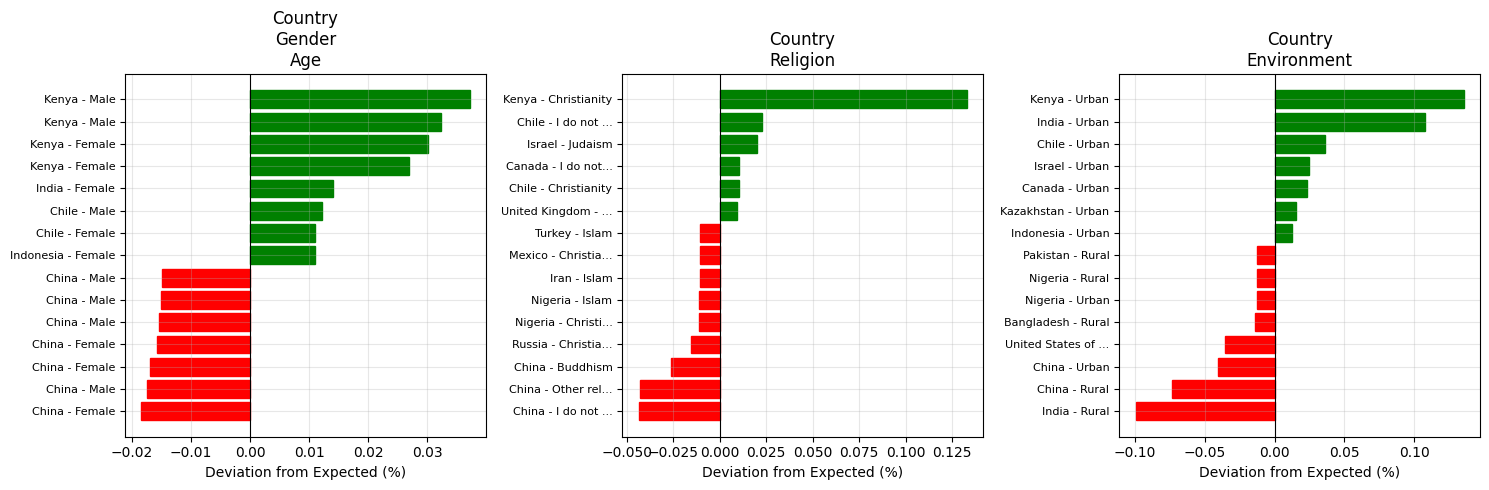


📊 OVERALL ALIGNMENT SCORE: 70.6%
   Average coverage across 11 dimensions


In [7]:
# Check alignment across different demographic cuts
alignment_report = analysis.check_alignment()

print("ALIGNMENT ANALYSIS")
print("=" * 80)
print(f"Checking how well survey categories align with benchmark data...\n")

# Summarize alignment by dimension
total_coverage = []
for dimension, stats in alignment_report.items():
    if stats['status'] == 'complete':
        print(f"{dimension}:")
        print(f"  Overall alignment: {stats['overall_alignment']:.1%}")
        
        total_coverage.append(stats['overall_alignment'])
        
        # Show any issues
        if stats['issues']:
            print("  Issues found:")
            for issue in stats['issues'][:3]:  # Show top 3 issues
                print(f"    • {issue['column']}: {issue['coverage']:.1%} coverage")
                if issue['unmatched_sample']:
                    print(f"      Missing: {', '.join(issue['unmatched_sample'][:3])}...")
        else:
            print("  ✓ Perfect alignment")
        print()
    else:
        print(f"{dimension}: {stats.get('reason', 'Unknown issue')}")
        print()

# Visualize alignment patterns for main dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

main_dimensions = ['Country × Gender × Age', 'Country × Religion', 'Country × Environment']

for idx, (dimension, ax) in enumerate(zip(main_dimensions, axes)):
    if dimension in analysis.benchmarks:
        # Get top deviations for this dimension
        try:
            segments = analysis.get_top_segments(dimension, n=15)
            
            if not segments.empty:
                # Sort by deviation for better visualization
                segments_sorted = segments.sort_values('deviation')
                
                # Plot horizontal bars
                y_pos = range(len(segments_sorted))
                bars = ax.barh(y_pos, segments_sorted['deviation'])
                
                # Color bars based on over/under representation
                colors = ['red' if d < 0 else 'green' for d in segments_sorted['deviation']]
                for bar, color in zip(bars, colors):
                    bar.set_color(color)
                
                # Customize plot
                ax.set_yticks(y_pos)
                
                # Create segment labels
                labels = []
                for _, seg in segments_sorted.iterrows():
                    label_parts = []
                    for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
                        if col in seg and pd.notna(seg[col]):
                            label_parts.append(str(seg[col]))
                    label = ' - '.join(label_parts[:2])  # Show first 2 parts
                    if len(label) > 20:
                        label = label[:17] + '...'
                    labels.append(label)
                
                ax.set_yticklabels(labels, fontsize=8)
                ax.axvline(x=0, color='black', linewidth=0.8)
                ax.set_xlabel('Deviation from Expected (%)')
                ax.set_title(dimension.replace(' × ', '\n'))
                ax.grid(True, alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'No data\n({str(e)[:30]}...)', 
                   ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Overall alignment score
if total_coverage:
    overall_alignment = np.mean(total_coverage) * 100
    print(f"\n📊 OVERALL ALIGNMENT SCORE: {overall_alignment:.1f}%")
    print(f"   Average coverage across {len(total_coverage)} dimensions")

## 7. Generate Comprehensive Report

The GRI module can generate detailed reports in multiple formats for sharing with stakeholders.

In [8]:
# Generate and save comprehensive report
output_dir = Path('../analysis_output')
output_dir.mkdir(exist_ok=True)

# Export analysis results
try:
    analysis.export(format='json', filepath=str(output_dir / f'{primary_survey.lower()}_analysis.json'))
    print(f"✅ Analysis results exported")
except Exception as e:
    print(f"Could not export results: {e}")

# Save key results for future use
results_summary = {
    'survey': primary_survey,
    'n_participants': len(analysis.survey_data),
    'gri_scores': results,
    'top_segments': all_segments[0].head(20).to_dict('records') if 'all_segments' in locals() and all_segments else [],
    'max_scores_by_dimension': max_scores_by_dimension if 'max_scores_by_dimension' in locals() else {},
    'alignment_score': overall_alignment if 'overall_alignment' in locals() else None
}

output_file = output_dir / f'{primary_survey.lower()}_advanced_analysis.json'
with open(output_file, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"✅ Analysis summary saved: {output_file}")

# Display summary dashboard
print("\n" + "="*80)
print(f"ADVANCED ANALYSIS SUMMARY - {primary_survey}")
print("="*80)
print(f"Overall GRI Score: {results['average_gri']:.4f}")

if 'max_average_gri' in locals():
    print(f"Maximum Achievable GRI: {max_average_gri:.4f}")
    print(f"Gap to Maximum: {max_average_gri - results['average_gri']:.4f}")

if 'overall_alignment' in locals():
    print(f"Alignment Score: {overall_alignment:.1f}%")

print("\n🎯 Key Insights:")
print(f"  • Survey has {len(analysis.survey_data):,} participants from {analysis.survey_data['country'].nunique()} countries")

if 'all_segments' in locals() and all_segments:
    top_segment = all_segments[0].iloc[0]
    print(f"  • Largest deviation: ", end="")
    seg_desc = []
    for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
        if col in top_segment and pd.notna(top_segment[col]):
            seg_desc.append(str(top_segment[col]))
    print(f"{' - '.join(seg_desc)} ({top_segment['deviation']:+.1%})")

if 'optimal_size' in locals() and optimal_size:
    print(f"  • Recommended sample size for GRI ≥ 0.7: {optimal_size:,} participants")

# Generate actionable recommendations
print("\n🎯 Top 3 Actions:")
recommendations = []

if 'all_segments' in locals() and all_segments:
    under_rep = all_segments[0][all_segments[0]['deviation'] < 0].head(3)
    for i, (_, seg) in enumerate(under_rep.iterrows(), 1):
        seg_desc = []
        for col in ['country', 'gender', 'age_group', 'religion', 'environment']:
            if col in seg and pd.notna(seg[col]):
                seg_desc.append(str(seg[col]))
        print(f"  {i}. Recruit more: {' - '.join(seg_desc)} (need {abs(seg['deviation']):.1%} more)")

Could not export results: 'GRIAnalysis' object has no attribute 'export'
✅ Analysis summary saved: ../analysis_output/gd3_advanced_analysis.json

ADVANCED ANALYSIS SUMMARY - GD3
Overall GRI Score: 0.3489
Maximum Achievable GRI: 0.8921
Gap to Maximum: 0.5432
Alignment Score: 70.6%

🎯 Key Insights:
  • Survey has 970 participants from 63 countries
  • Largest deviation: Kenya - Male - 18-25 (+3.7%)
  • Recommended sample size for GRI ≥ 0.7: 750.0 participants

🎯 Top 3 Actions:
  1. Recruit more: China - Female - 65+ (need 1.8% more)
  2. Recruit more: China - Male - 46-55 (need 1.7% more)
  3. Recruit more: China - Female - 46-55 (need 1.7% more)


## Summary

This notebook demonstrated the advanced capabilities of the GRI module:

1. **Monte Carlo Simulations** revealed the theoretical maximum GRI achievable and how the current survey compares
2. **Segment Analysis** identified specific demographic groups driving representativeness gaps
3. **Sample Size Analysis** showed the relationship between participant count and achievable GRI scores
4. **Survey Comparisons** tracked progress across multiple survey iterations
5. **Alignment Analysis** provided a detailed view of representation patterns
6. **Comprehensive Reporting** generated shareable reports with actionable insights

### Key Takeaways

- The GRI module significantly reduces code complexity while providing more powerful analysis
- Monte Carlo simulations help set realistic expectations for achievable representativeness
- Segment-level analysis provides specific, actionable recruitment targets
- Built-in visualization and reporting features make it easy to share findings

### Next Steps

1. Use the generated reports to plan recruitment strategies
2. Focus on the high-priority segments identified in the analysis
3. Consider the sample size recommendations for future surveys
4. Track progress by comparing GRI scores across survey iterations

For more details, see the comprehensive report generated in the `analysis_output` directory.